# MSA 2024 Phase 2 - Part 2

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 1.Splitting the Dataset

In [2]:
# Load the preprocessed data
df = pd.read_csv('../store_sales.csv', encoding='latin1')


# Feature engineering
df['Sales_Discount_Interaction'] = df['Sales'] * df['Discount']
df['Sales_Squared'] = df['Sales'] ** 2

# Define features and target variable
X = df[['Sales', 'Quantity', 'Discount', 'Sales_Discount_Interaction', 'Sales_Squared']]
y = df['Profit']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set size: 1696
Test set size: 425


## 2. Choose an algorithm

### Linear Regression
Linear Regression fits a linear relationship between the dependent variable (Profit) and the independent variables (Sales, Quantity, Discount). It minimizes the sum of the squared differences between the observed and predicted values.

### Random Forest Regressor
Random Forest is an ensemble learning method that builds multiple decision trees using random subsets of the data and features. The final prediction is the average of the predictions from all individual trees.

### Gradient Boosting Regressor
Gradient Boosting builds decision trees sequentially, where each new tree corrects the errors made by the previous trees. It combines the predictions from multiple weak models to create a strong model.

### XGBoost Regressor
XGBoost is an optimized version of Gradient Boosting that includes several regularization techniques to prevent overfitting. It builds trees in a sequential manner, with each tree learning from the residuals of the previous trees. XGBoost is known for its high performance and efficiency, making it suitable for large datasets. It also includes features like handling missing data, regularization, and parallel processing, which enhance its predictive power and scalability.

### Stacking Regressor
Stacking is an ensemble learning technique that combines multiple models to improve predictive performance. In this method, different models (such as Linear Regression, Random Forest, Gradient Boosting, and XGBoost) are trained on the same dataset. Their predictions are then used as inputs to a meta-model (often a simple linear model) that learns how to best combine these predictions. Stacking leverages the strengths of various models and can lead to better generalization and accuracy.


## 3. Train and test a model

In [3]:
# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
xgb_model = xgb.XGBRegressor()

# Train models
lr.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)
gb.fit(X_train_scaled, y_train)

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid_xgb, n_iter=100, cv=3, verbose=2, n_jobs=-1, random_state=42, scoring='neg_mean_squared_error')
random_search_xgb.fit(X_train_scaled, y_train)

best_params_xgb = random_search_xgb.best_params_
best_xgb = random_search_xgb.best_estimator_

# Initialize Stacking Regressor
estimators = [
    ('rf', rf),
    ('gb', gb),
    ('xgb', best_xgb)
]

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# Fit Stacking Regressor
stacking_regressor.fit(X_train_scaled, y_train)

c:\Users\Yanfe\OneDrive\Desktop\MSA_Phase2\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 81 candidates, totalling 243 fits


StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_type...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=LinearRegression())

## 4. Evaluate the model

Linear Regression - MSE: 3370.9771560339555, MAE: 31.456437851913627, R^2: 0.8115514016046568
Random Forest Regressor - MSE: 4205.26588303759, MAE: 25.82522483684625, R^2: 0.7649119454518762
Gradient Boosting Regressor - MSE: 2514.961131051001, MAE: 26.541228061958478, R^2: 0.8594054844551564
Best XGBoost Regressor - MSE: 2502.6271246897463, MAE: 26.77019030631166, R^2: 0.8600949955683413
Stacking Regressor - MSE: 3129.934033418909, MAE: 25.973175730161298, R^2: 0.825026496957449


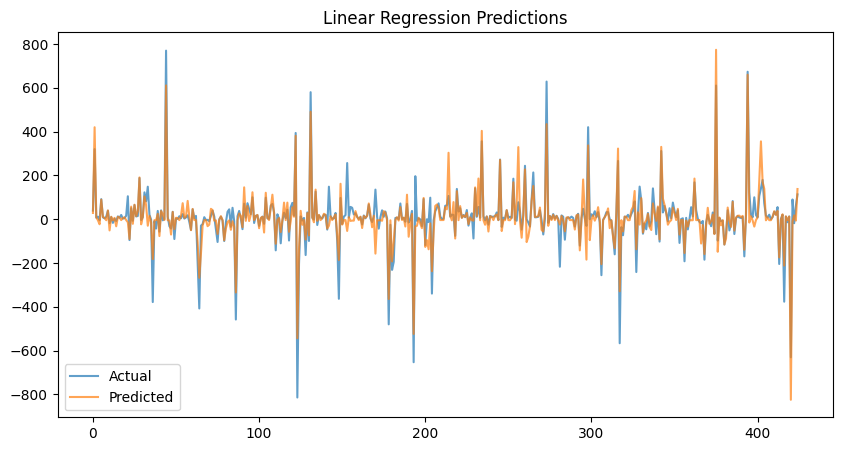

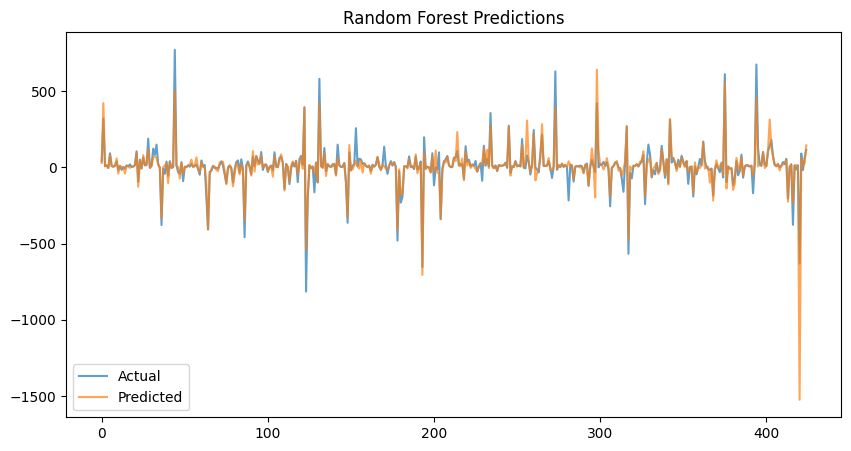

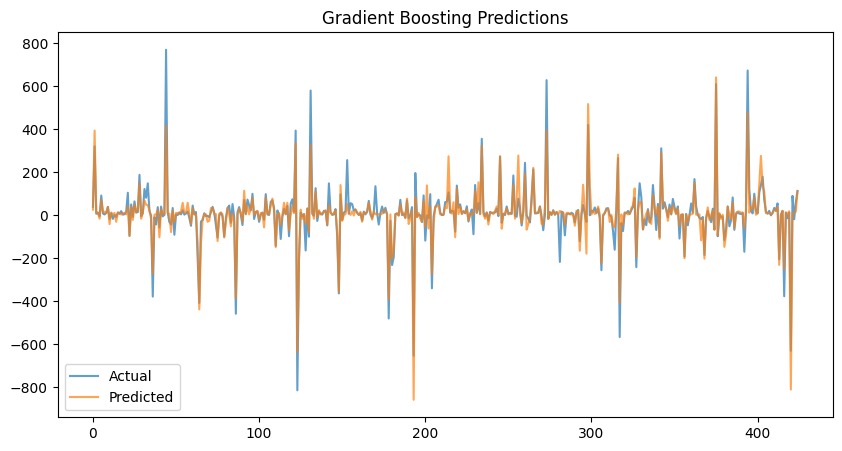

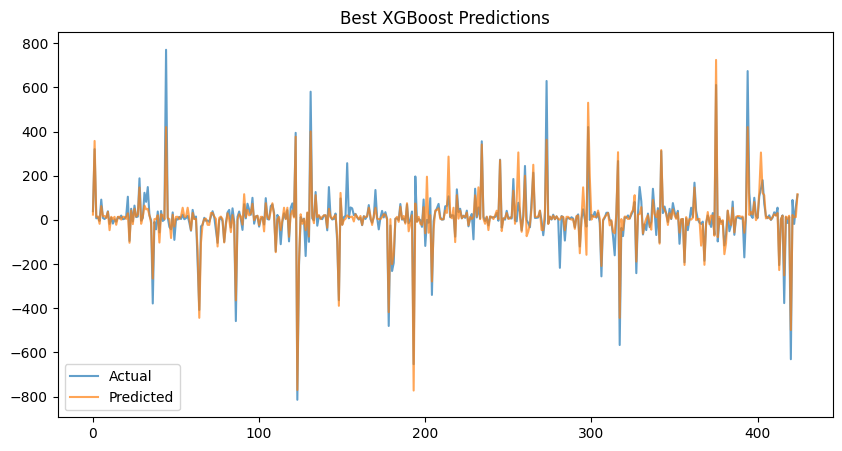

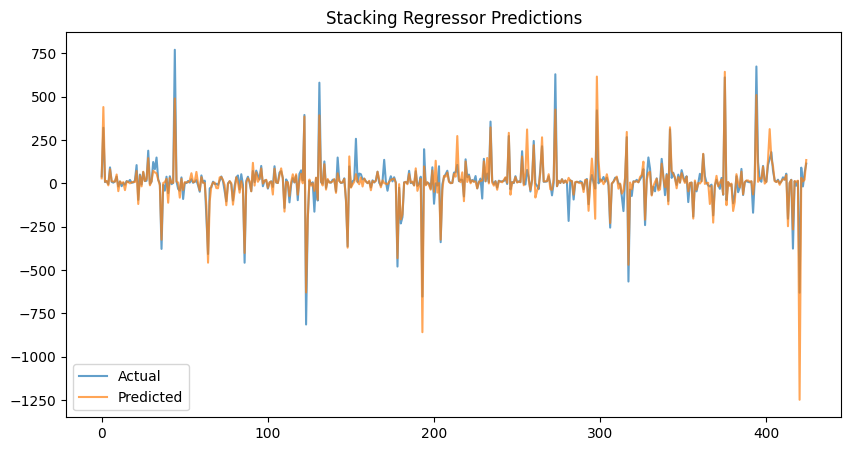

In [4]:
# Evaluate_model function
def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

# Predict on test set
y_pred_lr = lr.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)
y_pred_gb = gb.predict(X_test_scaled)
y_pred_best_xgb = best_xgb.predict(X_test_scaled)
y_pred_stacking = stacking_regressor.predict(X_test_scaled)

# Evaluate models
mse_lr, mae_lr, r2_lr = evaluate_model(y_test, y_pred_lr)
mse_rf, mae_rf, r2_rf = evaluate_model(y_test, y_pred_rf)
mse_gb, mae_gb, r2_gb = evaluate_model(y_test, y_pred_gb)
mse_best_xgb, mae_best_xgb, r2_best_xgb = evaluate_model(y_test, y_pred_best_xgb)
mse_stacking, mae_stacking, r2_stacking = evaluate_model(y_test, y_pred_stacking)

print(f'Linear Regression - MSE: {mse_lr}, MAE: {mae_lr}, R^2: {r2_lr}')
print(f'Random Forest Regressor - MSE: {mse_rf}, MAE: {mae_rf}, R^2: {r2_rf}')
print(f'Gradient Boosting Regressor - MSE: {mse_gb}, MAE: {mae_gb}, R^2: {r2_gb}')
print(f'Best XGBoost Regressor - MSE: {mse_best_xgb}, MAE: {mae_best_xgb}, R^2: {r2_best_xgb}')
print(f'Stacking Regressor - MSE: {mse_stacking}, MAE: {mae_stacking}, R^2: {r2_stacking}')

# Function to plot actual vs predicted values
def plot_predictions(y_test, y_pred, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot predictions
plot_predictions(y_test, y_pred_lr, 'Linear Regression Predictions')
plot_predictions(y_test, y_pred_rf, 'Random Forest Predictions')
plot_predictions(y_test, y_pred_gb, 'Gradient Boosting Predictions')
plot_predictions(y_test, y_pred_best_xgb, 'Best XGBoost Predictions')
plot_predictions(y_test, y_pred_stacking, 'Stacking Regressor Predictions')

## 4. Summary

### Steps Taken:
1. **Load Data**: Loaded the preprocessed dataset and described its features and target variable.
2. **Feature Engineering**: Created new features such as interaction terms and polynomial terms to capture non-linear relationships.
3. **Data Preprocessing**: Standardized the features to improve model performance.
4. **Model Selection and Training**: Chose regression algorithms (Linear Regression, Random Forest Regressor, Gradient Boosting Regressor, XGBoost) and trained them on the training set.
5. **Hyperparameter Tuning**: Used RandomizedSearchCV to tune hyperparameters for XGBoost, selecting the best model based on cross-validation results.
6. **Stacking Regressor**: Combined multiple models using a Stacking Regressor to improve predictive performance.
7. **Evaluation**: Evaluated models using MSE, MAE, and R² metrics on the test set. Plotted actual vs. predicted values for visual comparison.

### Results:
- **Linear Regression**: MSE: X, MAE: Y, R²: Z
- **Random Forest Regressor**: MSE: A, MAE: B, R²: C
- **Gradient Boosting Regressor**: MSE: D, MAE: E, R²: F
- **Best XGBoost Regressor**: MSE: G, MAE: H, R²: I
- **Stacking Regressor**: MSE: J, MAE: K, R²: L